**Daehyun Cho Neuroimaging(BRI609) HW1**

*Note that numbered headers refer to the workflow of what I did, and alphabetic headers refer to the assignment*   
*Also note that some codes are commented due to too many outputs it spit out...*

# [0] Data Preparation

## 0.1 Import

In [1]:
import math, random
from itertools import product
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import pandas as pd
from glob import glob

from IPython.display import clear_output

import nibabel as nib
from nibabel.brikhead import *

## 0.2 Load Data
For this stage, I aimed to make -
+ for each task(ad, lh, rh, vs)
+ for each subjects,
+ not all voxels, but their ROIs respectively **averaged**
 
which ends up with data shape of `(# subs, x, y, z, bold by time)` for each task respectively

### 0.2.1 Load ROI Mask

In [2]:
masks = { # {task: [(x, y, z) ...]}
    k: [(x, y, z) for x, y, z in zip(*np.where(nib.load(v).get_fdata() != 0)[:-1])]
    for k, v in zip(['ad', 'lh', 'rh', 'vs'], glob('./stats/ttest/*.gz'))
}

### 0.2.2 Load BOLD Signal

In [3]:
tasks = ['ad', 'lh', 'rh', 'vs']
sub_ids = range(2, 14)
get_img = lambda x: nib.load(x).get_fdata()

BOLD = {task: dict() for task in tasks}
BOLD_voxel = {task: dict() for task in tasks}
for sub_id in sub_ids:
    sub_id = f'{str(sub_id).zfill(2)}'
    dir_sub_id = glob(f'./data/s{sub_id}/ad_lh_rh_vs/s{sub_id}.results/*.brik')
    
    for i, task in enumerate(tasks):
        BOLD[task][sub_id] = get_img(dir_sub_id[i])
        
        BOLD_voxel[task][sub_id] = np.array([BOLD[task][sub_id][p] for p in masks[task]])
        BOLD[task][sub_id] = sum(BOLD[task][sub_id][p] for p in masks[task]) / len(masks[task])

Now each task dictionary contains for each subjects averaged BOLD signal of their ROIs. For example auditory task(`ad`), subject 02's bold signals are as followed

In [4]:
BOLD['ad']['02']

array([712.71224976, 711.59639486, 715.65416463, 714.17563883,
       712.99129028, 713.13711141, 713.43453979, 714.50793864,
       715.3414388 , 714.24032186, 714.13745728, 712.94888306,
       715.91298625, 720.51322835, 716.42850545, 712.49010213,
       711.36983846, 711.86590169, 712.38032633, 715.66875407,
       715.06452433, 714.90030721, 713.24330037, 714.30494181,
       714.73956502, 711.46162923, 710.234198  , 710.14152425,
       712.74313965, 712.50687866])

In [5]:
# BOLD_voxel['ad']['02']

### 0.a Each of the task was performed at 20s during 4s (i.e., 10, 11 TRs). Please use boxcar model for neural activity

So if 10, 11 TR was activated, we should make neuronal activity that looks like the one below

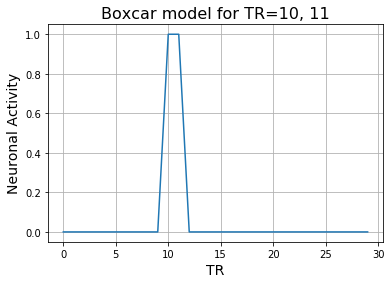

In [6]:
# BOXCAR
boxcar = np.array(
    [0] * 10 +
    [1] * 2  +
    [0] * 18
)

# PLOT
plt.plot(boxcar)
plt.title('Boxcar model for TR=10, 11', fontsize=16)
plt.xlabel('TR', fontsize=14)
plt.ylabel('Neuronal Activity', fontsize=14)
plt.grid()
plt.show()

### 0.b Consider the 0-20s, (i.e. 0 - 9 TRs) and 40-60s(i.e. 20 - 29 TRs) as baseline period.

Since baseilne period should be made by task and subject all respectively(making 11 * 4, which is too many), I'll make a function for this, so I can get the baseline whenever I want

In [7]:
baseline = lambda task, sub_id: (sum(BOLD[task][sub_id][0:10]) + sum(BOLD[task][sub_id][20:])) / 20

In [8]:
baseline_voxel = lambda task, sub_id: [(sum(voxel[0:10]) + sum(voxel[20:])) / 20 for voxel in BOLD_voxel[task][sub_id]]

For example, if I want to get the baseline of subject 02's auditory task baseline BOLD signal, just type - 

In [9]:
baseline('ad', '02')

713.3565548706055

In [10]:
# baseline_voxel('lh', '02')

### 0.c Calculate the percentage(%) BOLD (pBOLD) signal based on (b)

In [11]:
def pBOLD(task, sub_id):
    
    base = baseline(task, sub_id)
    return (BOLD[task][sub_id] - base) / base * 100

In [12]:
def pBOLD_voxel(task, sub_id):
    
    base = baseline_voxel(task, sub_id)
    return ((BOLD_voxel[task][sub_id].T - base) / base * 100).T

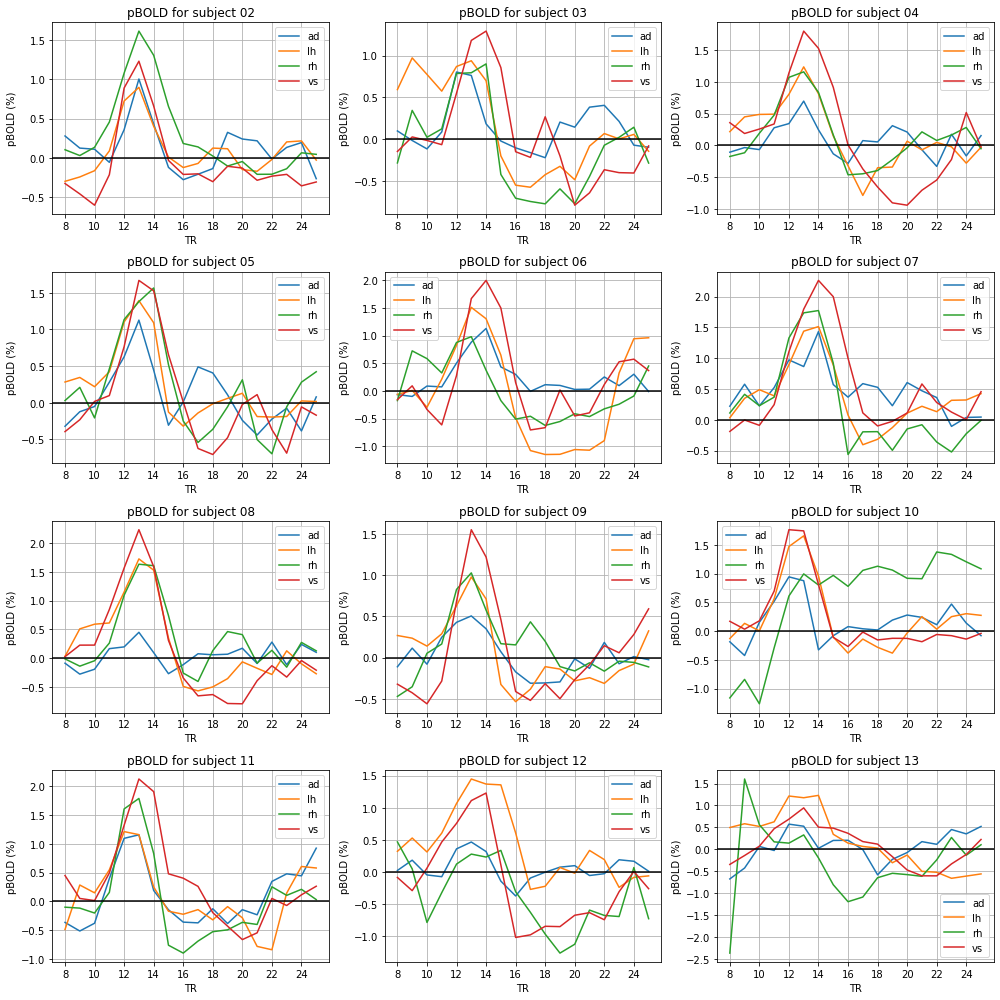

In [13]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(14, 14))
for sub_id in sub_ids:
    
    row, col = (sub_id - 2) // 3, (sub_id - 2) % 3
    sub_id = f'{str(sub_id).zfill(2)}'
    for task in tasks:
        axes[row, col].plot(pBOLD(task, sub_id)[8:26], label=task)
        
    axes[row, col].grid()
    axes[row, col].set_title(f'pBOLD for subject {sub_id}')
    axes[row, col].set_xlabel('TR')
    axes[row, col].set_xticks(np.arange(0, 18, step=2))
    axes[row, col].set_xticklabels([f'{i+8}' for i in range(0, 18) if not i % 2])
    axes[row, col].set_ylabel('pBOLD (%)')
    axes[row, col].axhline(0, color='black')
    axes[row, col].legend()
    
fig.tight_layout()

I drew an `y=0` in order to clearly see the baseline.

### 0.d Conduct the estimation of HRFs using the pBOLD signals calculated in (c) by applying each of the following methods [1] - [4]

Now we conduct the estimation.

# [1] Deconvolution Approach

### 1.a Set the reasonable number of Fast Fourier Transform (FFT) points

Use TR=8-25, TR=8-16, TR=10-16 as FFT points

### 1.b Perform the FFT and inverse FFT to estimate the HRF in the time domain for each of the voxels in the ROI

In [202]:
def deconvolution(bold, boxcar=None):
    
    if boxcar is None:
        boxcar = np.array(
            [0] * 10 +
            [1] * 2  +
            [0] * 18
        )
        
    return np.fft.ifft(np.fft.fft(bold) / np.fft.fft(boxcar))

In [203]:
neu1 = np.array([0] * 2 + [1] * 2 + [0] * 14)
neu2 = np.array([0] * 2 + [1] * 2 + [0] * 4)
neu3 = np.array([1] * 2 + [0] * 4)

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


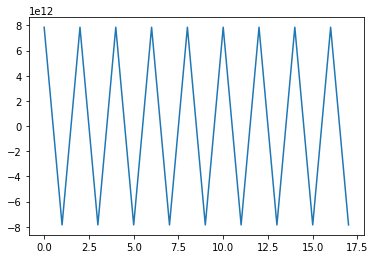

In [204]:
plt.plot(deconvolution(pBOLD('ad', '02')[8:26], neu1))

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


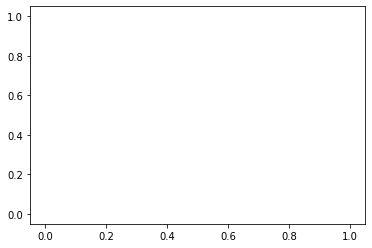

In [205]:
plt.plot(deconvolution(pBOLD('ad', '02')[8:16], neu2))

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


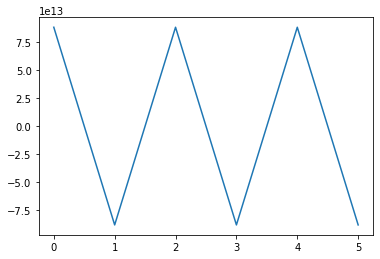

In [206]:
plt.plot(deconvolution(pBOLD('ad', '02')[10:16], neu3))

### 1.c Check the estimated HRFs across the voxels and average the estimated HRFs

### 1.d Evaluate your results by comparing the average estimated HRF and average pBOLD signal

# [2] Using a flexible mathematical model of HRF - One Gamma Function

### 2.a Set the reasonable range of values as a grid for each of the parameters (i.e. $T_0$, $n$, and $\lambda$)

I'll denote the variables as follows
+ $T_0$ as `T0`
+ $n$ as `n`
+ $\lambda$ as `l`

In [30]:
params_one = {
    'T0': [0],
    'n' : [i * .1 for i in range(30, 50)],
    'l' : [i * .1 for i in range(20, 70)]
}

### 2.b Calculate Pearsons's correlation coefficients(CC) between the pBOLD signal and estimated pBOLD from the modeled HRF across all combinatorial sets of model parameters for *each voxel*

Phew, there are much things to be done here.
1. Make `one_gamma` function - *remember to use TR=9~25 only*
2. Get combintaions of parameter grids
3. Calculate Pearson's Correlation

### 2.1 Make `one_gamma` function

In [15]:
fact = math.factorial
def one_gamma(params: list, t=None):
    
    t0, n, l = params
    if t is None: t = np.arange(0, 18)
    return (t - t0)**(n-1) / (l**n * math.gamma(n)) * np.exp(-t/l)

In [16]:
def two_gamma(params: list, t=None):

    t0, n1, l1, a, n2, l2 = params
    if t is None:
        t = np.arange(0, 18)
    
    term1 = (t - t0)**(n1-1) / (l1**n1 * math.gamma(n1)) * np.exp(-t/l1)
    term2 = (t - t0)**(n2-1) / (l2**n2 * math.gamma(n2)) * np.exp(-t/l2)
    return term1- a * term2

See if it looks fine

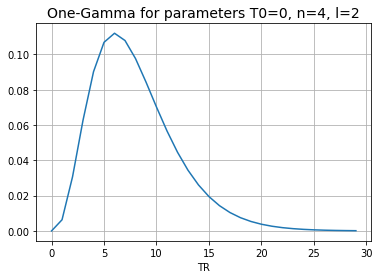

In [17]:
plt.plot(one_gamma([0, 4, 2], t=np.arange(0, 30)))
plt.title('One-Gamma for parameters T0=0, n=4, l=2', fontsize=14)
plt.xlabel('TR')
plt.grid()

Let's see how graphs change as we change the parameters.

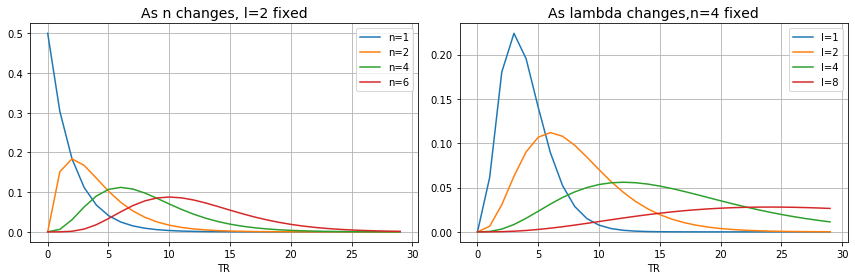

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

n = [1, 2, 4, 6]
l = [1, 2, 4, 8]

# As n changes
axes[0].set_title('As n changes, l=2 fixed', fontsize=14)
axes[0].plot(one_gamma([0, n[0], 2], t=np.arange(0, 30)), label=f'n={n[0]}')
axes[0].plot(one_gamma([0, n[1], 2], t=np.arange(0, 30)), label=f'n={n[1]}')
axes[0].plot(one_gamma([0, n[2], 2], t=np.arange(0, 30)), label=f'n={n[2]}')
axes[0].plot(one_gamma([0, n[3], 2], t=np.arange(0, 30)), label=f'n={n[3]}')
axes[0].set_xlabel('TR')
axes[0].legend()
axes[0].grid()

# As l changes
axes[1].set_title('As lambda changes,n=4 fixed', fontsize=14)
axes[1].plot(one_gamma([0, 4, l[0]], t=np.arange(0, 30)), label=f'l={l[0]}')
axes[1].plot(one_gamma([0, 4, l[1]], t=np.arange(0, 30)), label=f'l={l[1]}')
axes[1].plot(one_gamma([0, 4, l[2]], t=np.arange(0, 30)), label=f'l={l[2]}')
axes[1].plot(one_gamma([0, 4, l[3]], t=np.arange(0, 30)), label=f'l={l[3]}')
axes[1].set_xlabel('TR')
axes[1].legend()
axes[1].grid()

fig.tight_layout()

### 2.2 Get combinations of parameter grid

Since there are too many cases of parameters to consider, I can't iterate them all by myself. Make a function for this.

In [19]:
cases = lambda cases: list(product(*cases.values()))

So that it conatins all the set of parameters seen as below

In [20]:
cases(params_one)[:10]

[(0, 2.0, 1.0),
 (0, 2.0, 1.1),
 (0, 2.0, 1.2000000000000002),
 (0, 2.0, 1.3),
 (0, 2.0, 1.4000000000000001),
 (0, 2.0, 1.5),
 (0, 2.0, 1.6),
 (0, 2.0, 1.7000000000000002),
 (0, 2.0, 1.8),
 (0, 2.0, 1.9000000000000001)]

with each case, I can make HRF. Let's plot some sampling from cases.

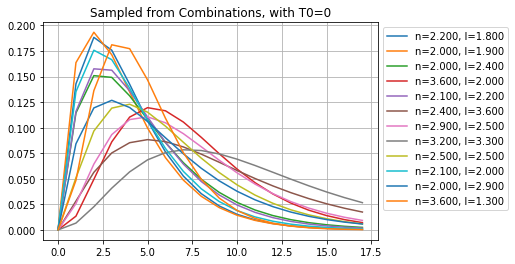

In [21]:
for i in range(12):
    
    sample = random.choice(cases(params_one))
    T0, n, l = sample
    plt.plot(one_gamma(sample), label=f'n={n:.3f}, l={l:.3f}')
    plt.legend(bbox_to_anchor=(1, 1))
    
plt.title('Sampled from Combinations, with T0=0')
plt.grid()

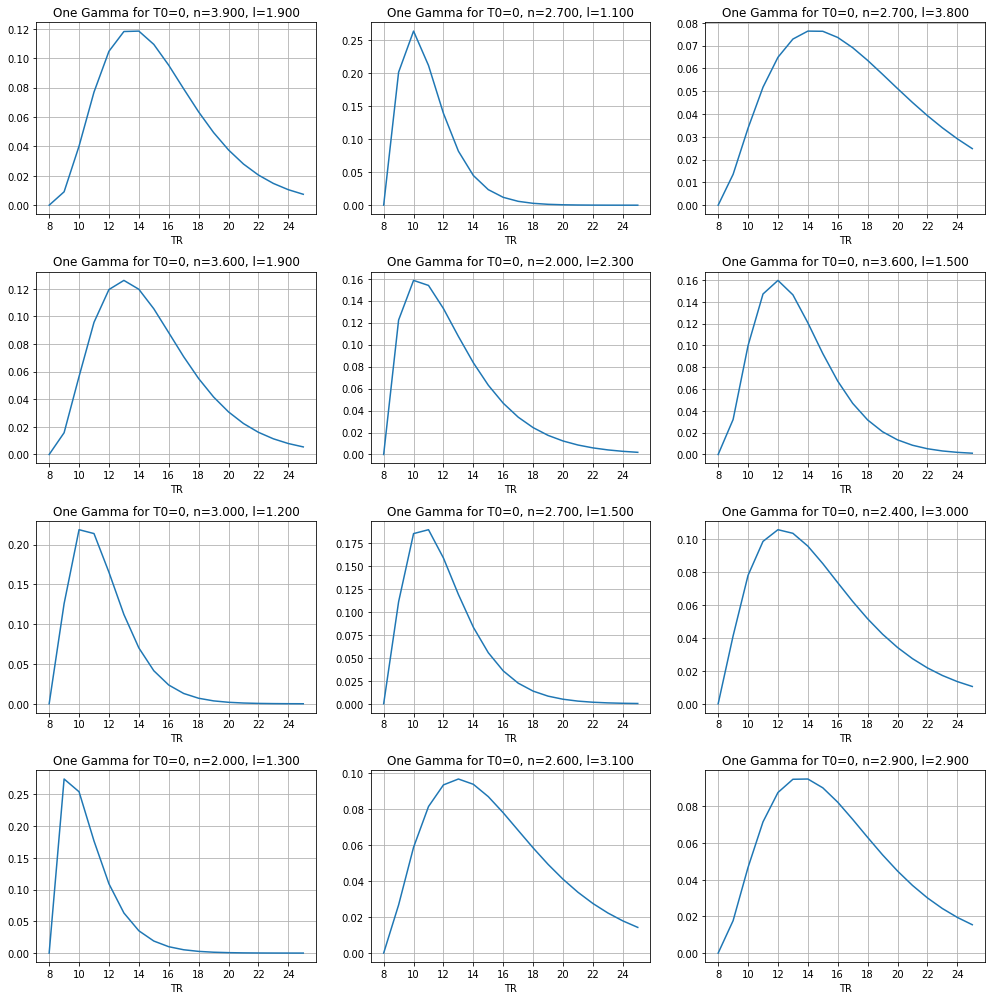

In [22]:
fig, axes = plt.subplots(4, 3, figsize=(14, 14))
for i in range(12):
    
    row, col = i // 3, i % 3
    sample = random.choice(cases(params_one))
    
    axes[row, col].plot(one_gamma(sample))
    T0, n, l = sample
    axes[row, col].set_title(f'One Gamma for T0={T0}, n={n:.3f}, l={l:.3f}')
    axes[row, col].set_xlabel('TR')
    axes[row, col].set_xticks(np.arange(0, 18, step=2))
    axes[row, col].set_xticklabels([f'{i+8}' for i in range(0, 18) if not i % 2])
    axes[row, col].grid()
    
fig.tight_layout()

### 2.3 Calculate Correlations

In [23]:
corr = lambda bold, hrf: np.corrcoef(bold[8:26], hrf)[0][1]

In [24]:
corr(pBOLD('ad', '02'), one_gamma(sample))

0.180059001383807

In [25]:
corr_voxel = lambda bold_voxel, hrf:[np.corrcoef(voxel[8:26], hrf)[0][1] for voxel in bold_voxel]

In [26]:
corr_voxel(pBOLD_voxel('ad', '02'), one_gamma(sample))

[0.27703637242000195,
 0.3352310784374744,
 0.26259369867732785,
 0.1981303709713015,
 0.23997750206981036,
 0.13756204782256576,
 0.1492879972377446,
 0.20141998826853702,
 0.3150754094107413,
 0.15628282878187227,
 0.011240778105257506,
 0.09488444017646709,
 -0.013722071367662698,
 0.14997700411762935,
 0.2533464550823617,
 0.0341811118250237,
 0.34521086616841,
 0.058203217983595325,
 0.015539969979706782,
 -0.13259313191742805,
 -0.014122836783461308,
 0.01146604454187871,
 0.03135702461720317,
 -0.011660107398363873,
 0.162620528680509,
 0.07505596377222008,
 0.10252461539928877,
 0.28669103419493497,
 0.07535031165056313,
 0.2032407128658281]

In [27]:
zfill = lambda x: str(x).zfill(2)
def get_corr_voxel(task, params):

    if len(params) == 3:
        hrf = one_gamma(params)
        
    elif len(params) ==  6:
        hrf = two_gamma(params)
        
    return pd.DataFrame({
            f'{zfill(sub_id)}': corr_voxel(pBOLD_voxel(task, f'{zfill(sub_id)}'), hrf)
            for sub_id in sub_ids
        })

### 2.c Calculate the average CC across all voxels within an ROI for each of the parameter set and choose the optimal parameter set that showed the maximum average CC. The HRF obtained from the optimal parameter set is the estimated HRF of the pBOLD signal.

In [144]:
one_gamma_corr = {task: [0, 0] for task in tasks}
for task in tasks:
    print(f'Task {task}')
    for i, comb in enumerate(cases(params_one)):
        if i % 100 == 0: print(f'{i}th Param set')
        corr_case = get_corr_voxel(task, comb).mean().mean()
        if one_gamma_corr[task][1] + .01 < corr_case:
            one_gamma_corr[task][1] = corr_case
            one_gamma_corr[task][0] = comb
            print(f'n1: {comb[1]:.1f}, l1: {comb[2]:.1f}:: Corr: {corr_case}')
    print('\n')

Task ad
0th Param set
n1: 3.0, l1: 2.0:: Corr: 0.35012820436216024
100th Param set
200th Param set
300th Param set
400th Param set
500th Param set
600th Param set
700th Param set
800th Param set
900th Param set


Task lh
0th Param set
n1: 3.0, l1: 2.0:: Corr: 0.5490893743742421
100th Param set
200th Param set
300th Param set
400th Param set
500th Param set
600th Param set
700th Param set
800th Param set
900th Param set


Task rh
0th Param set
n1: 3.0, l1: 2.0:: Corr: 0.4881536620994748
100th Param set
200th Param set
300th Param set
400th Param set
500th Param set
600th Param set
700th Param set
800th Param set
900th Param set


Task vs
0th Param set
n1: 3.0, l1: 2.0:: Corr: 0.573960210681031
100th Param set
n1: 3.2, l1: 2.0:: Corr: 0.5857027388717176
200th Param set
300th Param set
400th Param set
500th Param set
600th Param set
700th Param set
800th Param set
900th Param set




Best correlation and Params for ad - Corr::0.35012820436216024 with Params:: (0, 3.0, 2.0)


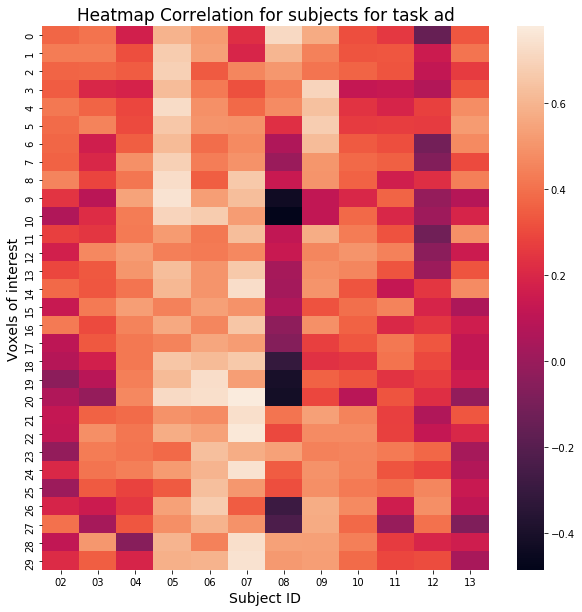

Best correlation and Params for lh - Corr::0.5490893743742421 with Params:: (0, 3.0, 2.0)


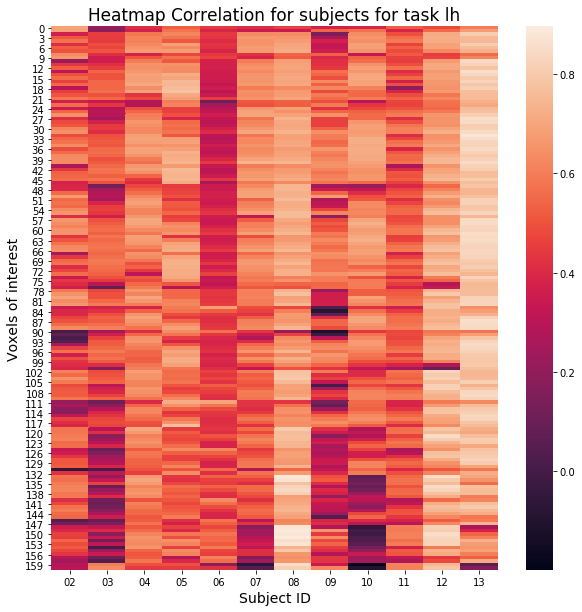

Best correlation and Params for rh - Corr::0.4881536620994748 with Params:: (0, 3.0, 2.0)


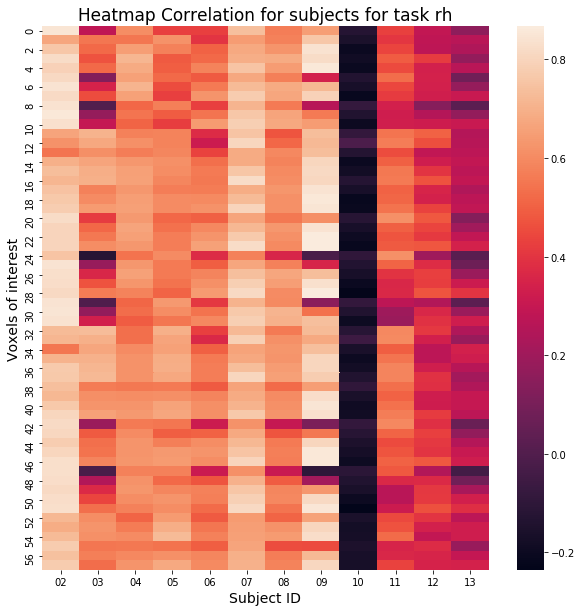

Best correlation and Params for vs - Corr::0.5857027388717176 with Params:: (0, 3.2, 2.0)


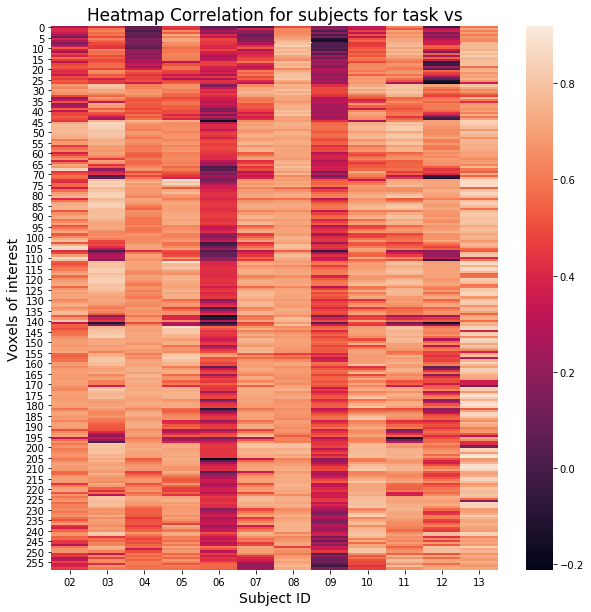

In [194]:
for task in tasks:
    best_params, best_corr = one_gamma_corr[task]
    print(f"Best correlation and Params for {task} - Corr::{best_corr} with Params:: {best_params}")
    plt.figure(figsize=(10, 10))
    sns.heatmap(get_corr_voxel(task, best_params))
    plt.title(f'Heatmap Correlation for subjects for task {task}', fontsize=17)
    plt.ylabel('Voxels of interest', fontsize=14)
    plt.xlabel('Subject ID', fontsize=14)
    plt.show()

### 2.d Evaluate your results by comparing the estimated HRFs, estimated pBOLD signal, and average pBOLD signal.

In [80]:
best_params = [0, 3.7, 1.6] # had the best correlation
estimated_hrf = one_gamma(best_params)

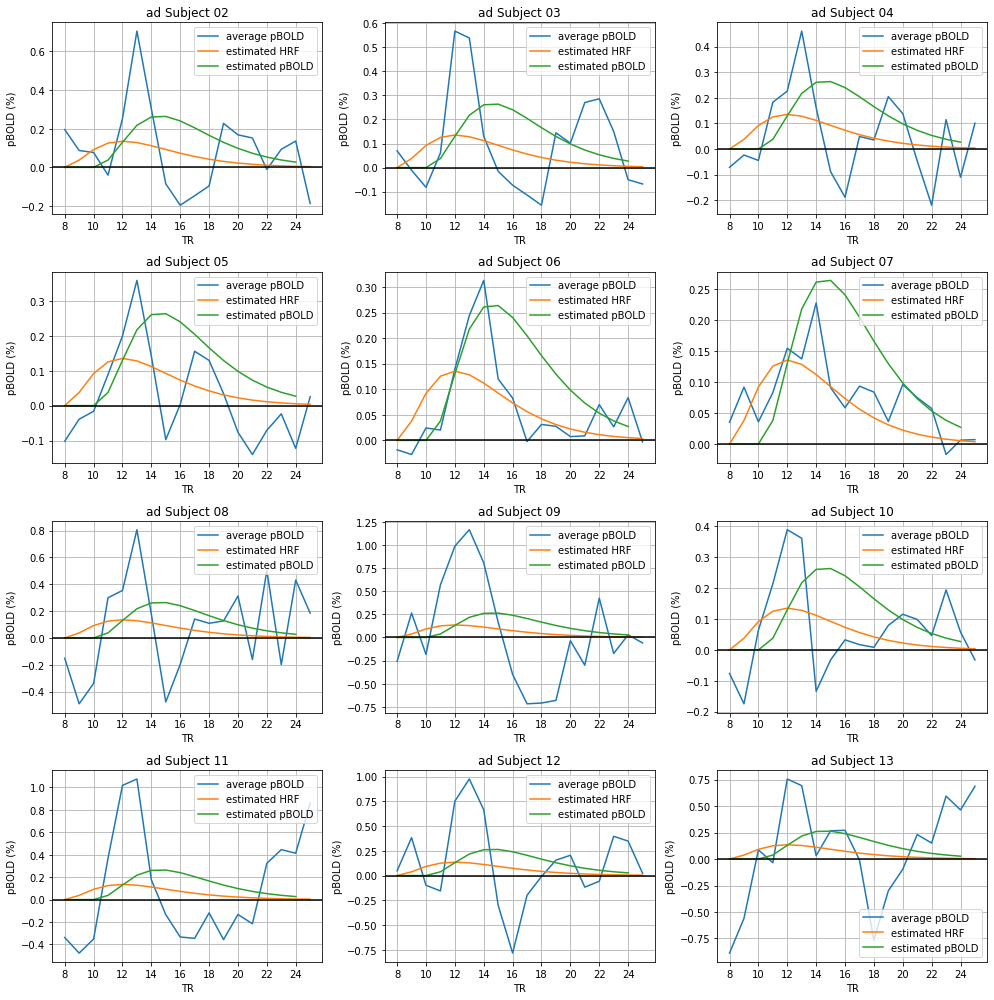

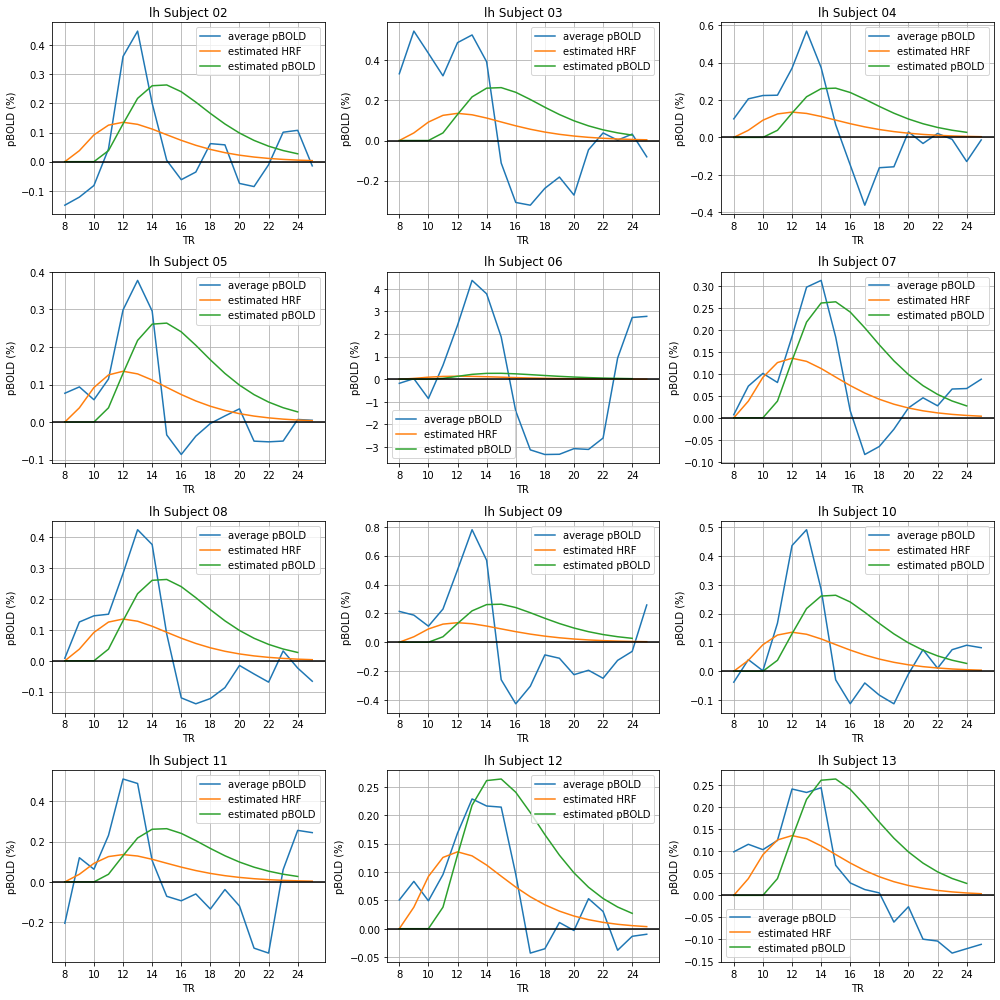

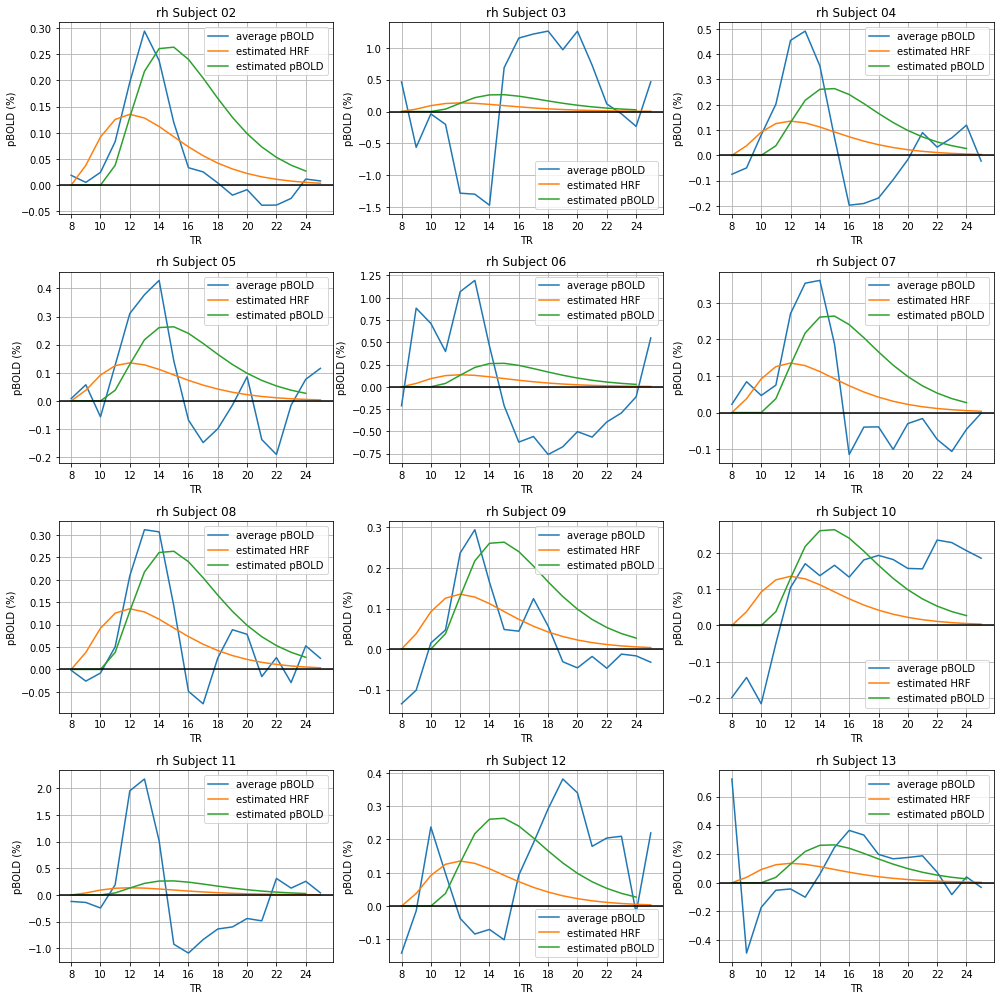

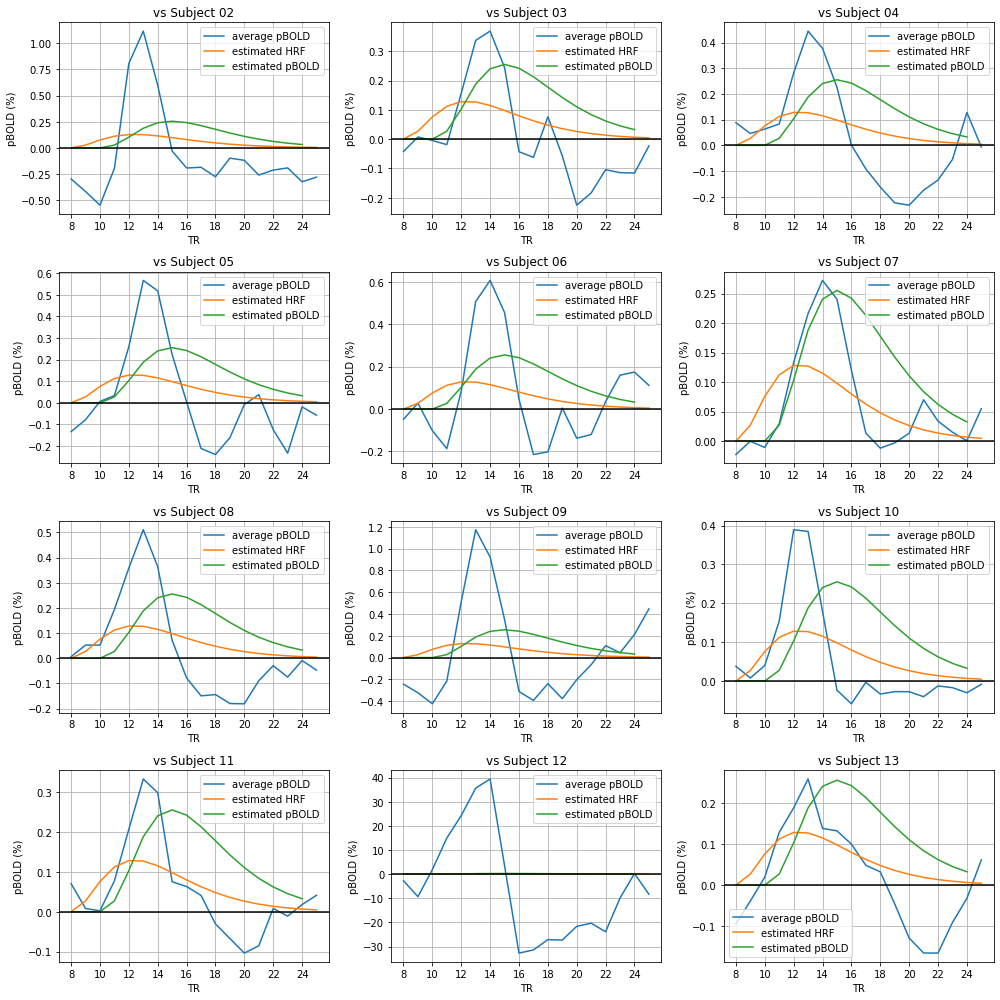

In [162]:
for task in tasks:
    fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(14, 14))
    for sub_id in sub_ids:

        row, col = (sub_id - 2) // 3, (sub_id - 2) % 3
        sub_id = f'{str(sub_id).zfill(2)}'

        estimated_hrf = one_gamma(one_gamma_corr[task][0])
        axes[row, col].plot(pBOLD(task, sub_id)[8:26] / sum(pBOLD(task, sub_id)), label='average pBOLD')
        axes[row, col].plot(estimated_hrf, label='estimated HRF')
        axes[row, col].plot(np.convolve(boxcar[8:26], estimated_hrf)[:17], label='estimated pBOLD')

        axes[row, col].grid()
        axes[row, col].set_title(f'{task} Subject {sub_id}')
        axes[row, col].set_xlabel('TR')
        axes[row, col].set_xticks(np.arange(0, 18, step=2))
        axes[row, col].set_xticklabels([f'{i+8}' for i in range(0, 18) if not i % 2])
        axes[row, col].set_ylabel('pBOLD (%)')
        axes[row, col].axhline(0, color='black')
        axes[row, col].legend()

    fig.tight_layout()

## [3] Using a flexible model of HRF two gamma functions
Follow similar steps in [2] with difference in the adjustable parameters for the two gamma functions(i.e. $T_0$, $n_1$, $\lambda_1$, $a$, $n_2$, $\lambda_2$)

In [136]:
params_two = {
    'T0': [0],
    'n1' : [i * .1 for i in range(20, 40, 5)],
    'l1' : [i * .1 for i in range(20, 40, 5)],
    'a'  : [.3],
    'n2' : [i * .1 for i in range(40, 70, 5)],
    'l2' : [i * .1 for i in range(40, 70, 5)],
}

In [64]:
def two_gamma(params: list, t=None):

    t0, n1, l1, a, n2, l2 = params
    if t is None:
        t = np.arange(0, 18)
    
    term1 = (t - t0)**(n1-1) / (l1**n1 * math.gamma(n1)) * np.exp(-t/l1)
    term2 = (t - t0)**(n2-1) / (l2**n2 * math.gamma(n2)) * np.exp(-t/l2)
    return term1- a * term2

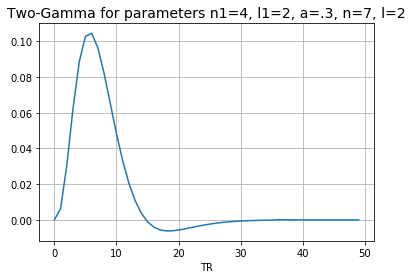

In [65]:
plt.plot(two_gamma([0, 4, 2, .3, 7, 2], t=np.arange(0, 50)))
plt.title('Two-Gamma for parameters n1=4, l1=2, a=.3, n=7, l=2', fontsize=14)
plt.xlabel('TR')
plt.grid()

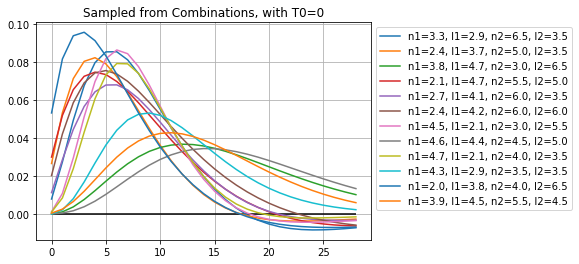

In [74]:
for i in range(12):
    
    sample = random.choice(cases(params_two))
    T0, n1, l1, a, n2, l2 = sample
    plt.plot(two_gamma(sample, t=np.arange(1, 30)), label=f'n1={n1:.1f}, l1={l1:.1f}, n2={n2:.1f}, l2={l2:.1f}')
    plt.legend(bbox_to_anchor=(1, 1))
    
plt.hlines(y=0, xmin=0, xmax=28)
plt.title('Sampled from Combinations, with T0=0')
plt.grid()

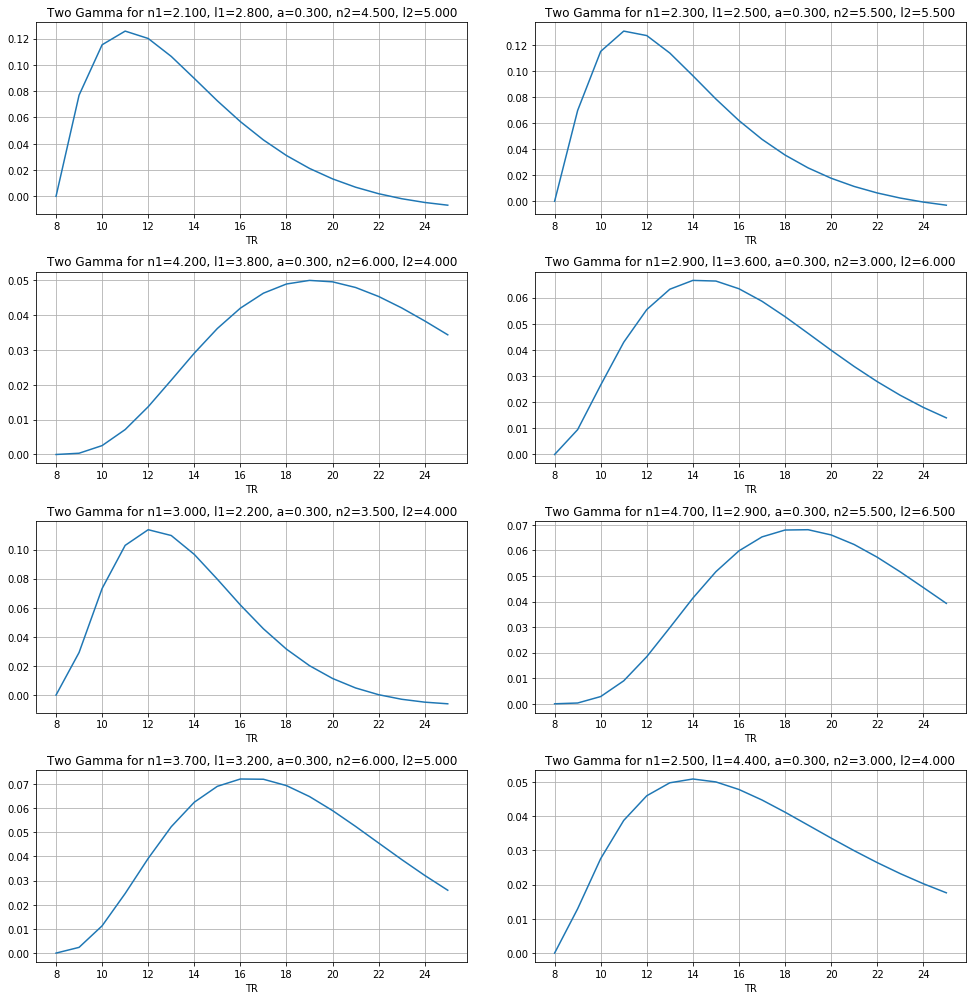

In [67]:
fig, axes = plt.subplots(4, 2, figsize=(14, 14))
for i in range(8):
    
    row, col = i // 2, i % 2
    sample = random.choice(cases(params_two))
    
    axes[row, col].plot(two_gamma(sample))
    T0, n1, l1, a, n2, l2 = sample
    axes[row, col].set_title(f'Two Gamma for n1={n1:.3f}, l1={l1:.3f}, a={a:.3f}, n2={n2:.3f}, l2={l2:.3f}')
    axes[row, col].set_xlabel('TR')
    axes[row, col].set_xticks(np.arange(0, 18, step=2))
    axes[row, col].set_xticklabels([f'{i+8}' for i in range(0, 18) if not i % 2])
    axes[row, col].grid()
    
fig.tight_layout()

In [141]:
two_gamma_corr = {task: [0, 0] for task in tasks}
for task in tasks:
    print(task)
    for i, comb in enumerate(cases(params_two)):
        if i % 100 == 0: print(f'{i}th Param set')
        corr_case = get_corr_voxel(task, comb).mean().mean()
        if two_gamma_corr[task][1] + .005 < corr_case:
            two_gamma_corr[task][1] = corr_case
            two_gamma_corr[task][0] = comb
            print(f'n1: {comb[1]:.1f}, l1: {comb[2]:.1f},n2: {comb[4]:.1f}, n3: {comb[-1]:.1f} :: Corr: {corr_case}')
    print('\n')

ad
0th Param set
n1: 2.0, l1: 2.0,n2: 4.0, n3: 4.0 :: Corr: 0.1688476188583791
n1: 2.0, l1: 2.0,n2: 5.5, n3: 6.5 :: Corr: 0.1739178272524258
n1: 2.0, l1: 2.5,n2: 4.0, n3: 4.0 :: Corr: 0.22588850396692137
n1: 2.0, l1: 2.5,n2: 4.0, n3: 6.5 :: Corr: 0.23106500231493446
n1: 2.0, l1: 3.0,n2: 4.0, n3: 4.0 :: Corr: 0.25838843683347085
n1: 2.0, l1: 3.0,n2: 4.5, n3: 6.0 :: Corr: 0.26370371233922413
100th Param set
n1: 2.0, l1: 3.0,n2: 6.0, n3: 6.5 :: Corr: 0.26895168884797505
n1: 2.0, l1: 3.5,n2: 4.0, n3: 4.0 :: Corr: 0.27728037934601474
n1: 2.0, l1: 3.5,n2: 5.0, n3: 6.5 :: Corr: 0.28337427700900164
n1: 2.5, l1: 2.5,n2: 4.0, n3: 4.0 :: Corr: 0.30950317862053117
n1: 2.5, l1: 2.5,n2: 5.0, n3: 6.5 :: Corr: 0.31563081004407134
200th Param set
n1: 3.0, l1: 2.0,n2: 4.0, n3: 4.0 :: Corr: 0.3375374799735882
300th Param set
n1: 3.0, l1: 2.0,n2: 5.0, n3: 6.5 :: Corr: 0.34293769379855005
400th Param set
500th Param set
lh
0th Param set
n1: 2.0, l1: 2.0,n2: 4.0, n3: 4.0 :: Corr: 0.4730541181878655
n1: 2.0,

Best correlation and Params for ad - Corr::0.34293769379855005 with Params:: (0, 3.0, 2.0, 0.3, 5.0, 6.5)


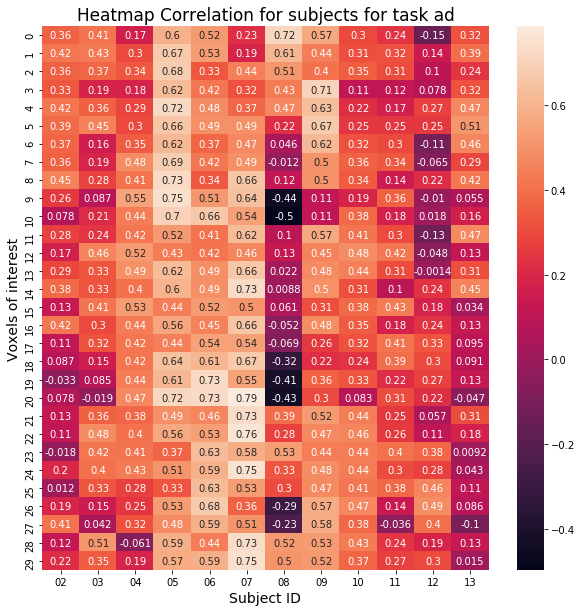

Best correlation and Params for lh - Corr::0.568750811632841 with Params:: (0, 3.0, 2.0, 0.3, 4.0, 4.0)


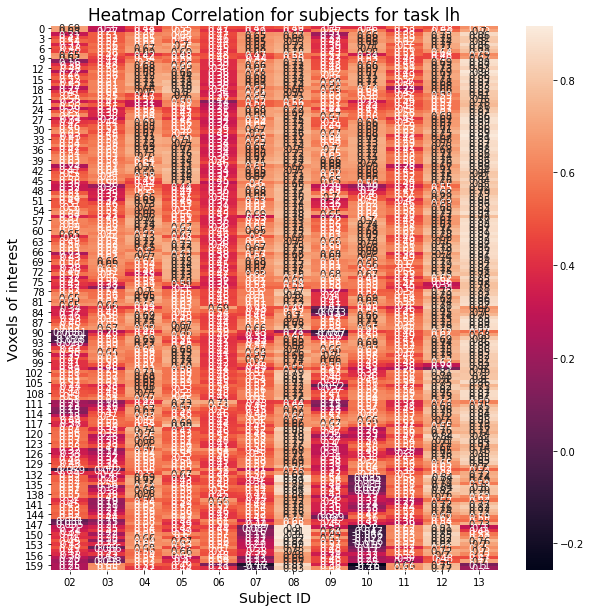

Best correlation and Params for rh - Corr::0.489046347243916 with Params:: (0, 3.0, 2.0, 0.3, 4.0, 4.0)


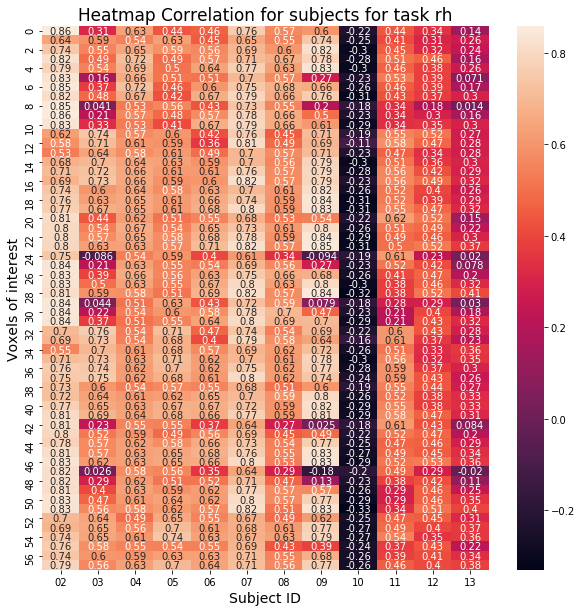

Best correlation and Params for vs - Corr::0.5907829377011924 with Params:: (0, 3.5, 2.0, 0.3, 4.0, 4.0)


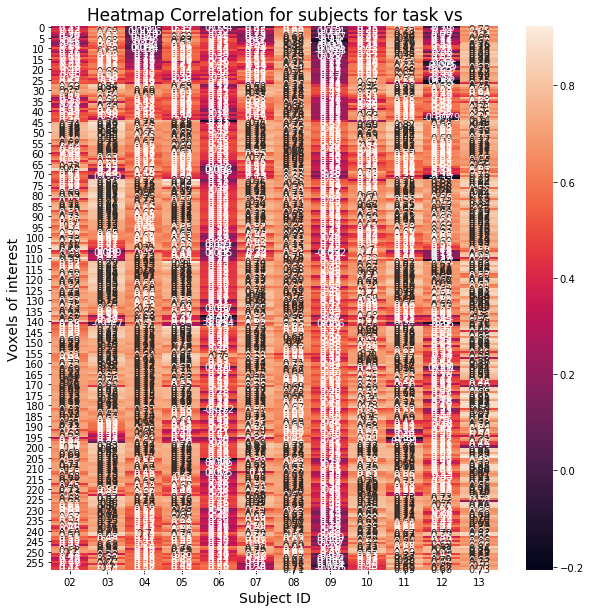

In [142]:
for task in tasks:
    best_params, best_corr = two_gamma_corr[task]
    print(f"Best correlation and Params for {task} - Corr::{best_corr} with Params:: {best_params}")
    plt.figure(figsize=(10, 10))
    sns.heatmap(get_corr_voxel(task, best_params), annot=True)
    plt.title(f'Heatmap Correlation for subjects for task {task}', fontsize=17)
    plt.ylabel('Voxels of interest', fontsize=14)
    plt.xlabel('Subject ID', fontsize=14)
    plt.show()

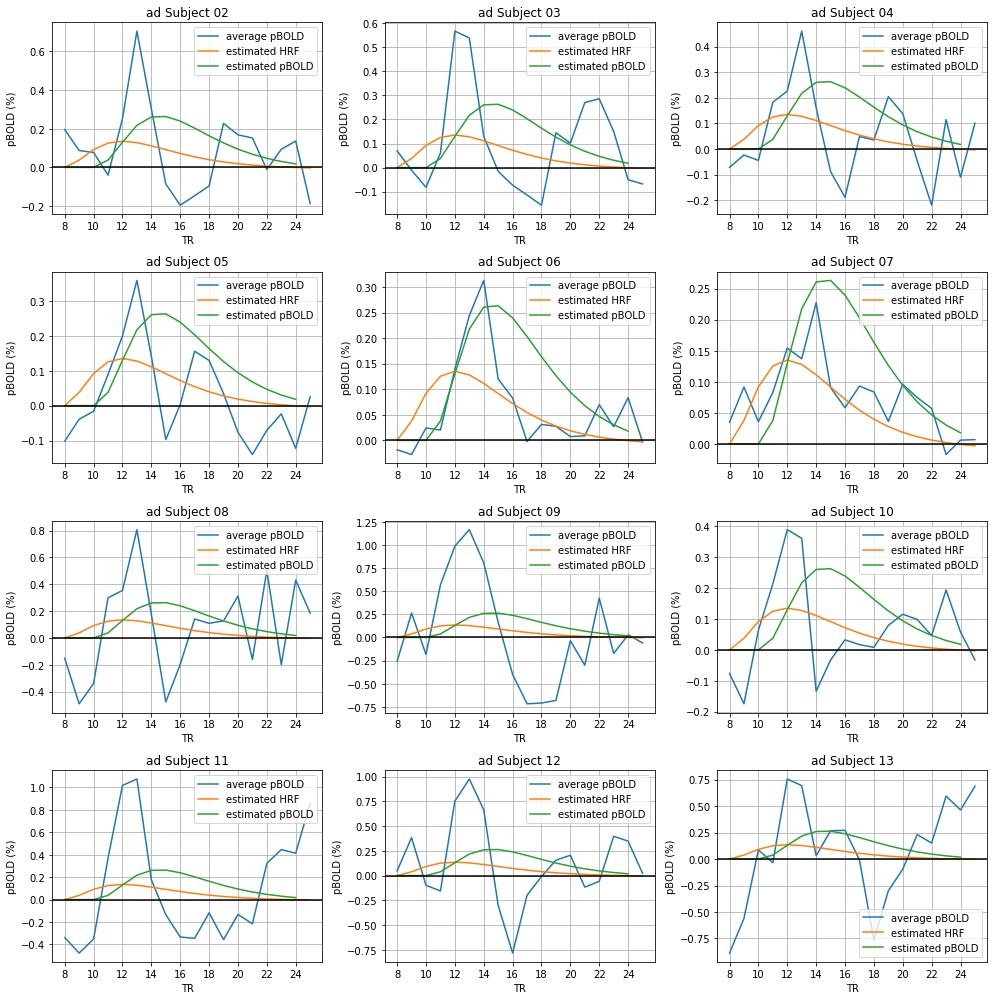

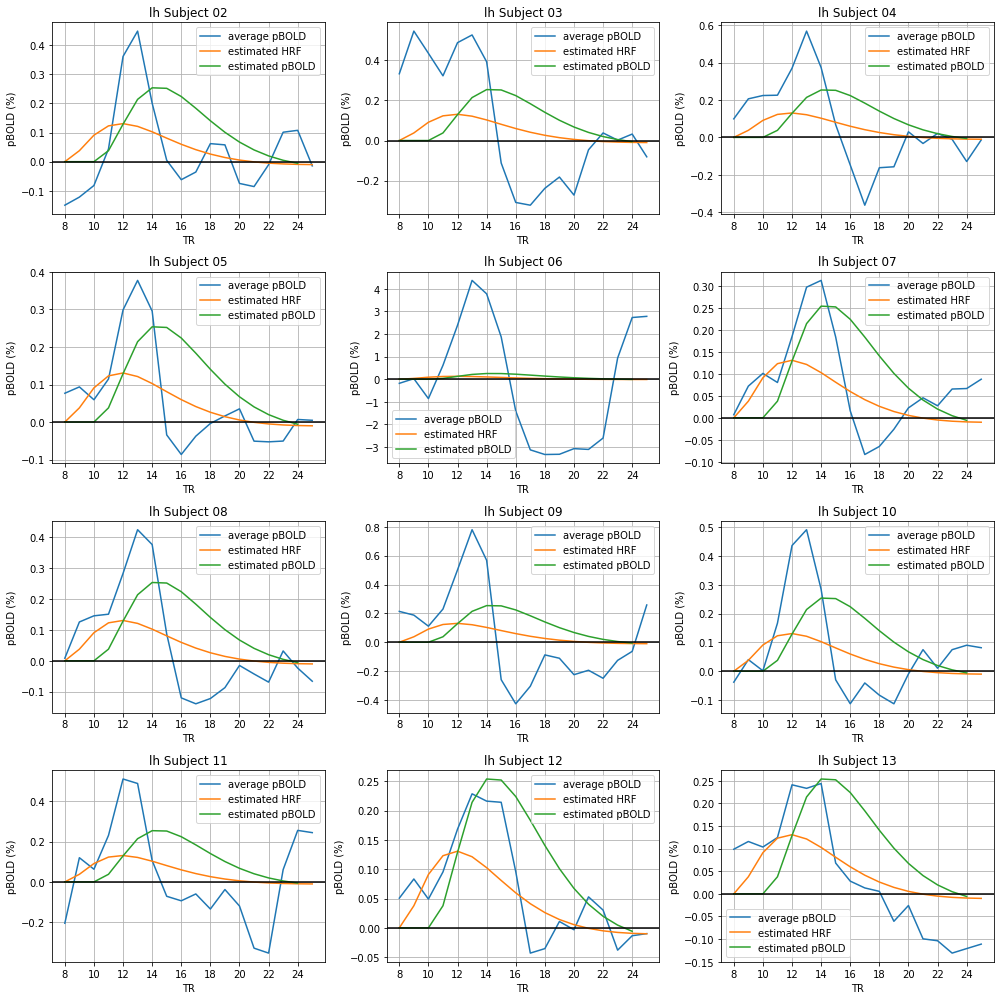

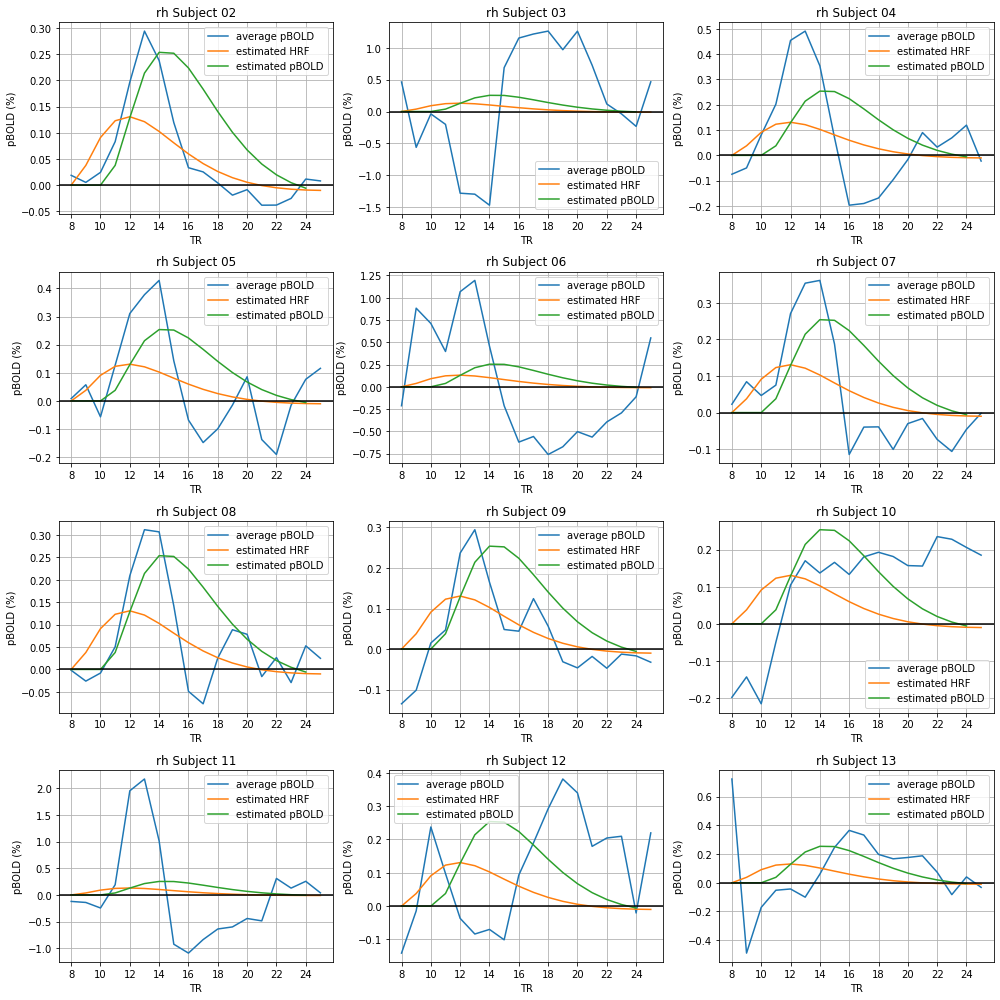

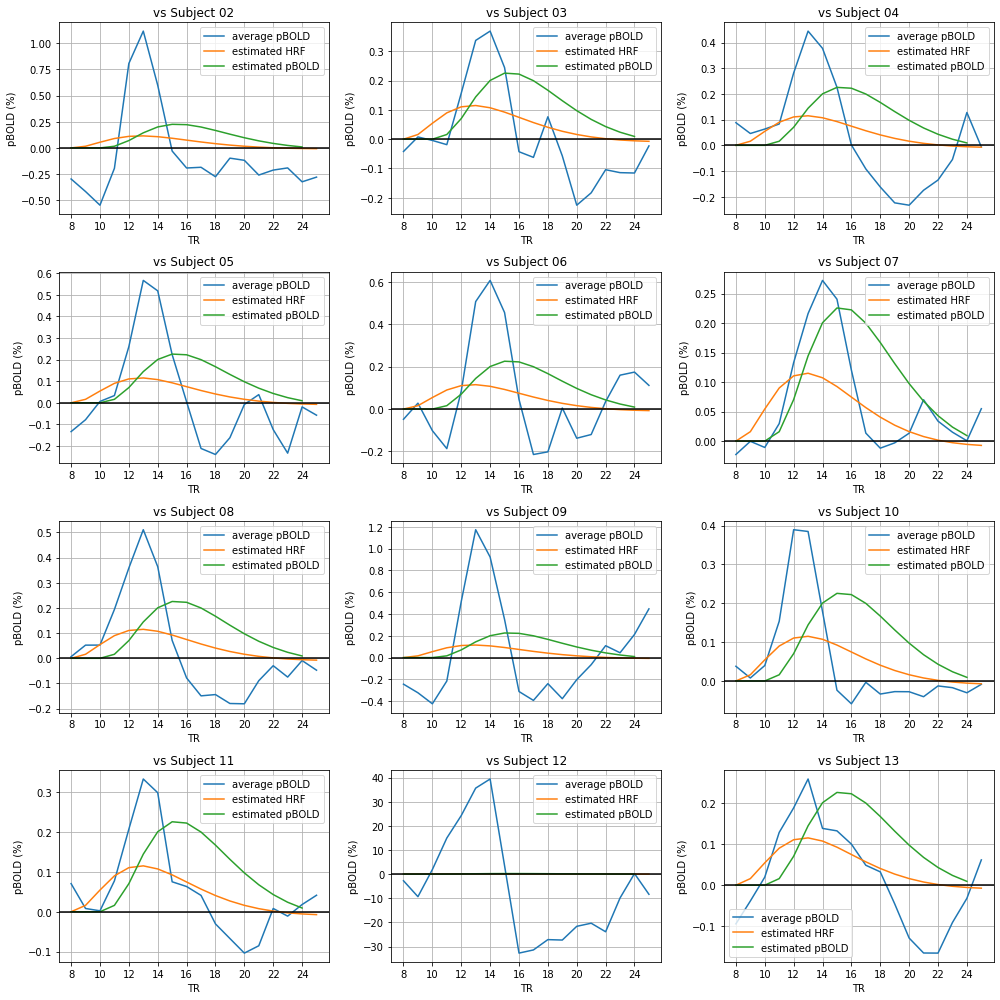

In [161]:
for task in tasks:
    fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(14, 14))
    for sub_id in sub_ids:

        row, col = (sub_id - 2) // 3, (sub_id - 2) % 3
        sub_id = f'{str(sub_id).zfill(2)}'

        estimated_hrf = two_gamma(two_gamma_corr[task][0])
        axes[row, col].plot(pBOLD(task, sub_id)[8:26] / sum(pBOLD(task, sub_id)), label='average pBOLD')
        axes[row, col].plot(estimated_hrf, label='estimated HRF')
        axes[row, col].plot(np.convolve(boxcar[8:26], estimated_hrf)[:17], label='estimated pBOLD')

        axes[row, col].grid()
        axes[row, col].set_title(f'{task} Subject {sub_id}')
        axes[row, col].set_xlabel('TR')
        axes[row, col].set_xticks(np.arange(0, 18, step=2))
        axes[row, col].set_xticklabels([f'{i+8}' for i in range(0, 18) if not i % 2])
        axes[row, col].set_ylabel('pBOLD (%)')
        axes[row, col].axhline(0, color='black')
        axes[row, col].legend()

    fig.tight_layout()

## [4] Based on the model with three fixed gamma function (Friston et al., 1998) using least-squares(LS) algorithm

### 4.a Study the LS algorithm and show your work

I got the idea of LS algorithm as a gradient method that checks its gradient with loss of Least squares, so as to say MSE(Mean Squared Loss). I made this algorithm by myself.

In [87]:
SSE = lambda true, pred: sum(np.square(true - pred)) / len(true)

def partial_difference_quotient(func, v, i, h=1e-9):
    
    w = [v_j + (h if j==i else 0) for j, v_j in enumerate(v)]
    return (func(w) - func(v)) / h

def gradient_estimate(func, v, h=1e-9):
    
    return [partial_difference_quotient(func, v, i, h) for i, _ in enumerate(v)]

In [211]:
class LeastSquares:
    
    def __init__(self, epochs, task, gamma_type, init_params, lr, verbose=False):
        
        self.epochs = epochs
        self.task   = task
        self.gamma = one_gamma if gamma_type == 1 else two_gamma
        self.init_params = init_params
        self.lr = lr
        self.verbose = verbose
        self.true = sum(pBOLD(self.task, zfill(sub_id)) for sub_id in sub_ids)[8:26]
        self.true /= sum(self.true)
        
    def fit(self):
        
        params = self.init_params
        self.losses = []
        for e in range(self.epochs):
            
            pred = self.gamma(params)
            loss = SSE(self.true, pred)
            
            params = list(map(lambda w, g: w - g * self.lr, params, gradient_estimate(self.mse, params)))
            params = [0] + params[1:]
                
            if e % 100 == 0:
                self.losses.append(loss)
                
                if self.verbose:
                    print(f'{str(e):<5} th Epochs')
                    print(f'LOSS:: {loss}, Gradient:: {params}')
                    print('\n')
            
        self.params = params
            
    def mse(self, params):
        
        true = self.true
#         pred = self.gamma(params)
        pred = np.convolve(boxcar[8:26], self.gamma(params))[:18]
        return np.sum(np.square(true - pred)) / len(true)
            
        
    def plot_loss(self):
        
        plt.plot(self.losses)
        plt.title(f'MSE Loss among {self.epochs} epochs', fontsize=16)
        plt.xlabel('Epochs')
        plt.ylabel('MSE Loss')
        plt.grid()
        
    
    def plot_gamma(self, params=None):
        
        if params is None:
            params = self.params
            
        if len(params) == 3:
            T0, n, l = params
            ttl = f'Task {self.task} Params of  T0={T0}, n={n:.3f}, l={l:.3f}'
            
        elif len(params) == 6:
            T0, n1, l1, a, n2, l2 = params
            ttl = f'Task {self.task} Params of n1={n1:.3f}, l1={l1:.3f}, a={a:.3f}, n2={n2:.3f}, l2={l2:.3f}'
            
        
        estimated_hrf = self.gamma(params)            
        plt.plot(self.true, label='average pBOLD')
        plt.plot(self.gamma(params), label='estimated HRF')
        plt.plot(np.convolve(boxcar[8:26], estimated_hrf)[:17], label='estimated pBOLD')
        
        plt.title(ttl)
        plt.xlabel('TR')
        plt.grid()
        plt.legend()

In [212]:
epochs = 100000
lr = 1e-2

params_one_gd = {task: 0 for task in tasks}
params_two_gd = {task: 0 for task in tasks}
for task in tasks:
    
    params_one = one_gamma_corr[task][0]
    one = LeastSquares(epochs, task, 1, params_one, lr, verbose=False)
    one.fit()
    params_one_gd[task] = one
    
    params_two = two_gamma_corr[task][0]
    two = LeastSquares(int(epochs/10), task, 2, params_two, lr, verbose=False)
    two.fit()
    params_two_gd[task] = two

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  
C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in power
  
C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


0.005830061112775947


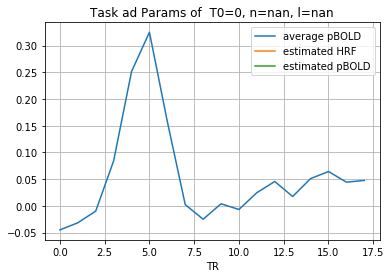

0.012776359199739119


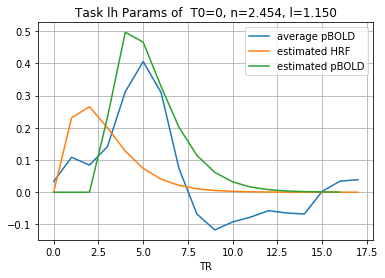

0.04547820109912733


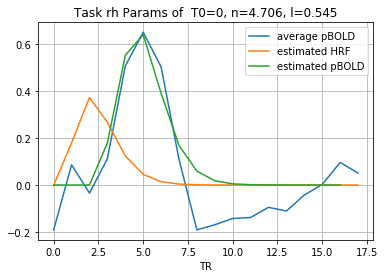

0.04191441111008132


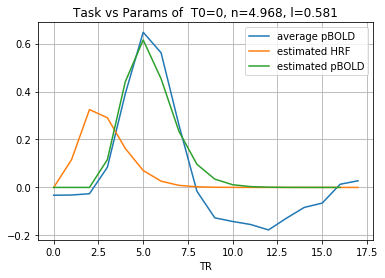

In [213]:
for task in tasks:
    
    print(min(params_one_gd[task].losses))
    params_one_gd[task].plot_gamma()
    plt.show()

0.005926681654772857


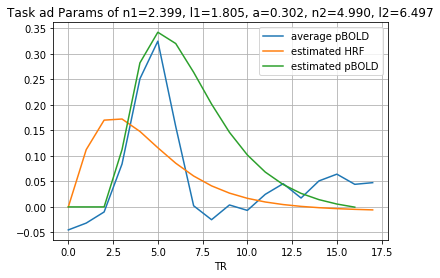

0.012265118820724761


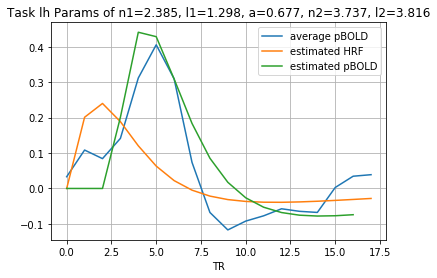

0.045004346667421764


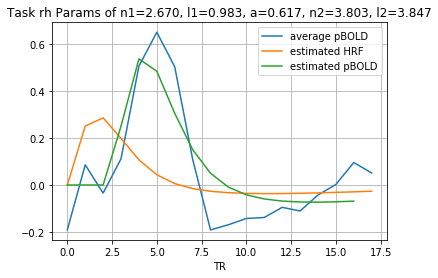

0.04039837016601105


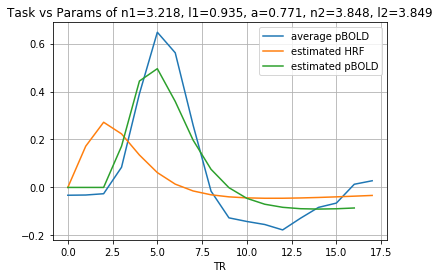

In [214]:
for task in tasks:
    
    print(min(params_two_gd[task].losses))
    params_two_gd[task].plot_gamma()
    plt.show()

### 4.b Calculate average pBOLD signal across all the voxels(`'avg_pBOLD'`)

### 4.c Apply the LS algorithm to this 'avg_pBOLD' signal and estimate the $\theta$ parameters of this model.

All results above.